In [1]:
import sys
sys.path.append('../../')

import jax
import jax.numpy as np
import numpy as onp
import os
import matplotlib.pyplot as plt
from discretization import *
from solver import *
from plot import *
from setupAM import *

os.environ["CUDA_VISIBLE_DEVICES"]="2"
jax.config.update("jax_enable_x64", True)
%matplotlib notebook

In [2]:
Nx,Ny,Nz = 500,100,100
domain = [5e-3,1e-3,5e-4]
dX,xc,yc,zc = generate_mesh(domain,[Nx,Ny,Nz])
T_ref = 295.

In [3]:
# customized material properties and functions
T_l = 1623.
T_s = 1563.
latent_heat = 290e3
rho = 8440.

def cond_func(T):
    # k(T), values from Gan et al. (2021)
    return 0.0163105*np.clip(T,T_ref,T_s)+4.5847 

def temp_to_enthalpy(T):
    # h(T) = int(cp*T) + L, values from Gan et al. (2021)
    h = ( (np.clip(T,a_max=T_s)-T_ref)*(0.2441*(T_ref+np.clip(T,a_max=T_s))/2.+338.39) + 
          (np.clip(T,a_min=T_s)-T_s)*(0.2441*T_s+338.39) +
          (np.clip(T,T_s,T_l)-T_s)/(T_l-T_s)*latent_heat)
    return rho*h

In [4]:
# customized BC parameters and functions
def toolpath(t):
    speed = .8 # scan speed
    x0,y0 = 5e-4,5e-4
    xl = x0 + t*speed 
    yl = y0
    return xl,yl

def update_BC(t,T_top,k):
    P = 195.  # power
    eta = 0.43  # absorptivity
    r = 5e-5  # 1/e^2 radius
    h = 10. # conv. coefficient
    xl,yl = toolpath(t)
    q_laser = 2*P*eta/np.pi/r**2*np.exp(-2*((xc[:,:,[-1]]-xl)**2+(yc[:,:,[-1]]-yl)**2)/r**2)
    q_conv = -h*(T_top-T_ref)
    # top surf: laser + conv., other surfs: adiabatic
    BCs = [[1,1,1,1,1,1],[0.,0.,0.,0.,0.,(q_laser+q_conv)/k[2][:,:,[-1]]]]
    return BCs

In [5]:
def energy_residual(T,T0,BCs,k):  
    T_bc = get_bound_values(T,BCs,dX)

    h = temp_to_enthalpy(T)
    h0 = temp_to_enthalpy(T0)
    
    res = (h-h0)/dt*dX[0]*dX[1]*dX[2] - diffusion(T,T_bc,k,dX)    
    return res.flatten()

In [6]:
@jax.jit
def time_integration(t,T0,T0_top,k):
    
    BCs = update_BC(t,T0_top,k) #update energy BC
    
    def A_fn(f):
        T = f.reshape((Nx,Ny,Nz,-1))
        return energy_residual(T,T0,BCs,k)
    dofs = T0.flatten()
    dofs,it = solver_nonlinear(A_fn,dofs,max_it = max_it,tol=1e-5,alpha=.6) ### examination: Newton step size < 1 when adding latent heat

    T = dofs.reshape((Nx,Ny,Nz,-1))
    k = update_cond(cond_func,T0,BCs,dX)
    T_top = T[:,:,[-1],:] + dX[2]/2.*BCs[1][-1]
    
    return T,it,k,T_top

In [7]:
### initialization
T0 = np.zeros_like(xc) + T_ref
T0_top = T0[:,:,[-1],:]
k = update_cond(cond_func,T0,[[1,1,1,1,1,1],[0.,0.,0.,0.,0.,0]],dX)
dt = 1e-5
t = 0.

In [8]:
%%time
max_it = 100
for i in range(0,500):
    T0,it,k,T0_top = time_integration(t,T0,T0_top,k)
        
    if it < max_it:
        if i%20 == 0:
            print(f'Time step: {i}')
            print(f'converged in {it} itertations')
    else:
        print(f'time step: {i}')
        print(f'reached max iterations!')
 
    t = t+dt

Time step: 0
converged in 9 itertations
Time step: 20
converged in 10 itertations
Time step: 40
converged in 10 itertations
Time step: 60
converged in 10 itertations
Time step: 80
converged in 10 itertations
Time step: 100
converged in 10 itertations
Time step: 120
converged in 10 itertations
Time step: 140
converged in 10 itertations
Time step: 160
converged in 10 itertations
Time step: 180
converged in 10 itertations
Time step: 200
converged in 10 itertations
Time step: 220
converged in 10 itertations
Time step: 240
converged in 10 itertations
Time step: 260
converged in 10 itertations
Time step: 280
converged in 10 itertations
Time step: 300
converged in 10 itertations
Time step: 320
converged in 10 itertations
Time step: 340
converged in 10 itertations
Time step: 360
converged in 9 itertations
Time step: 380
converged in 9 itertations
Time step: 400
converged in 9 itertations
Time step: 420
converged in 9 itertations
Time step: 440
converged in 9 itertations
Time step: 460
converge

<IPython.core.display.Javascript object>


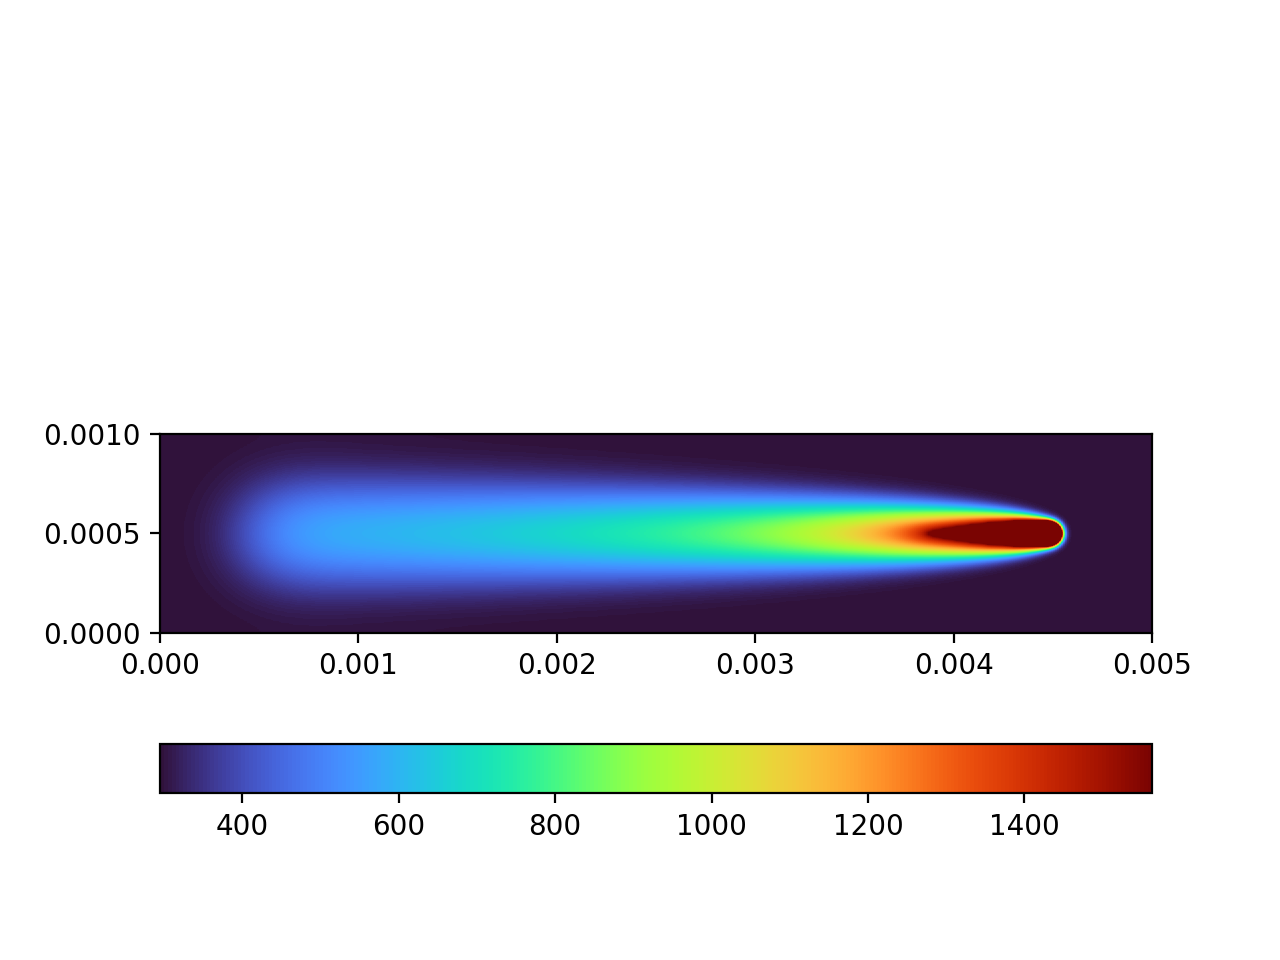

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
pcm=plt.imshow(T0_top[:,:,-1,0].T,origin='lower',cmap='turbo',vmax=1563,extent=[0.,domain[0],0.,domain[1]])
plt.colorbar(pcm,orientation='horizontal')

In [10]:
(T0_top[:,50,-1,0]>1563).sum()

DeviceArray(68, dtype=int64)